## Radial Distribution Function Tutorial

This module contains functions for calculating radial distribution functions from a series of diffraction images obtained in 4D-STEM mode from a FEM experiment. The process follows closely along the procedure described in Ref. [1]. The data presented in this notebook are that of amorphous silicon taken on the TEAM 0.5. 

#### Procedure Outline

1) Load data and perform necessary preprocessing

2) Get polar transform of diffraction series and correct for any elliptical distortions

3) Generate a radial intensity profile and get a corresponding diffraction space coordinate vector

4) Calculate and fit the single atom scattering factor to the tails of the radial intensity profile (see Ref [2]).

5) Calculate the structure factors $\phi(q)$ and applying any masking/zero padding

6) Perform a discrete sine transform to obtain the radial distribution functions G(r).


### 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
from scipy import optimize
import h5py
from time import time

import py4DSTEM
from py4DSTEM.process import rdf
from py4DSTEM.process.utils import print_progress_bar
from py4DSTEM.process.utils import cartesianDataAr_to_polarEllipticalDataAr
from py4DSTEM.file.io import read, append, FileBrowser

In [2]:
# Open processing file
fp_pr = "/media/AuxDriveB/Data/20190627_aSi_Shiteng/aSi1_processing.h5"

# Browse File 
browser = FileBrowser(fp_pr)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    avg_DP_ROI                          DiffractionSlice    
   1    virtual_images                      RealSlice           
   2    ROI                                 PointList           
   3    dq                                  PointList           
   4    ellipse_params                      PointList           
   5    braggpeaks                          PointListArray      


In [3]:
# Load data from processing file
ave_DP = browser.get_dataobject('avg_DP_ROI').data
virtual_images = browser.get_dataobject('virtual_images')
ROI = browser.get_dataobject('ROI')
dq= browser.get_dataobject('dq')
ellipse_params = browser.get_dataobject('ellipse_params')
browser.close()

dq = dq.data[0][0]
virtual_ADF_image = virtual_images.slices['ADF']
virtual_BF_image = virtual_images.slices['BF']
ellipse_params = (ellipse_params.data['x0'][0],
                  ellipse_params.data['y0'][0],
                  1,
                  ellipse_params.data['B'][0]/ellipse_params.data['A'][0],
                  ellipse_params.data['phi'][0])

Q_Nx,Q_Ny = ave_DP.shape
R_Nx,R_Ny = virtual_ADF_image.shape

### Polar Transform 

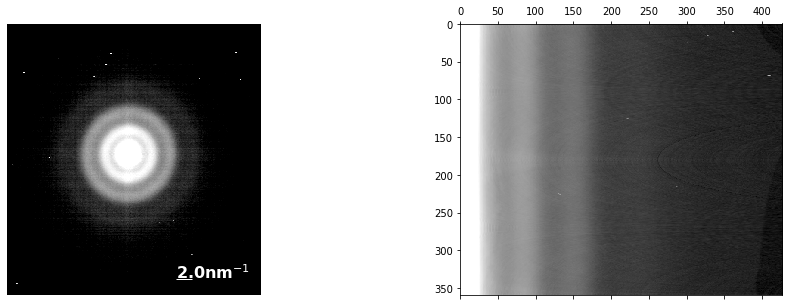

In [100]:
# Polar-elliptical transform

power = 0.1
nstd = 3
nstd_tl,nstd_tu = 1,1.5

rmax = int(np.min((ellipse_params[0],Q_Nx-ellipse_params[0],ellipse_params[1],Q_Ny-ellipse_params[1])))

scalebar_location = [Q_Ny-Q_Ny/3, Q_Nx-Q_Ny/15]
scalebar_size = [2/(10*dq),3]
scalebar_label = str(np.round(dq*10*scalebar_size[0],0))+'nm'+'$^{-1}$'
scalebar_color = 'w'

polarEllipticalData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=ave_DP,
                                    params=ellipse_params,
                                    dr=1,
                                    r_range=rmax,
                                    dtheta=np.radians(1),
                                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_DP**power, vmin=np.mean(ave_DP**power), vmax=np.mean(ave_DP**power)+nstd*np.std(ave_DP**power))
scalebar = Rectangle((scalebar_location[0],scalebar_location[1]), scalebar_size[0],scalebar_size[1], color=scalebar_color)
ax1.add_patch(scalebar)
ax1.text(x=scalebar_location[0], y =scalebar_location[1]-(scalebar_size[1]/2)-1, s=scalebar_label, fontweight='bold', fontsize= 16, color = scalebar_color)
ax2.matshow(polarEllipticalData.data**power, vmin=np.mean(polarEllipticalData**power)-nstd_tl*np.std(polarEllipticalData**power), vmax=np.mean(polarEllipticalData**power)+nstd_tu*np.std(polarEllipticalData**power))
ax1.axis('off')
#ax2.axis('off')
plt.show()

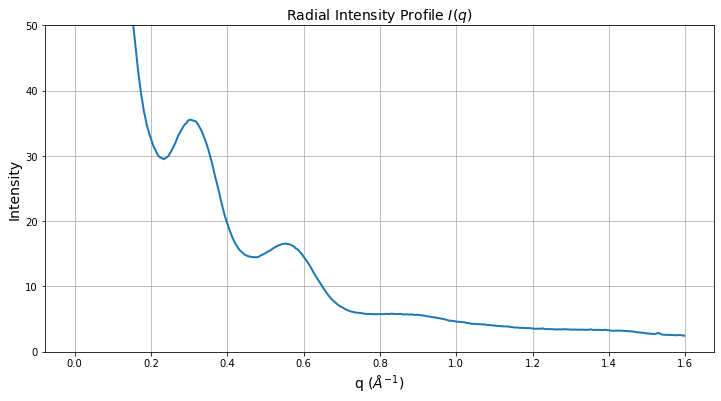

In [21]:
# Polar-elliptical integral

I_q = np.average(polarEllipticalData,axis=0)
q_arr = rr[0,:]*dq

# Plot
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(q_arr,I_q,linewidth=2)
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax.set_ylabel('Intensity',fontsize=14)
ax.set_title('Radial Intensity Profile $I(q)$',fontsize=14)
ax.grid()
ax.set_ylim(0, 50)
plt.show()

### 3. Single Atom Scattering Factor 
Here, the single atom scattering factor $f^2(q)$ is calculated using the parameterization provided in Ref. [2]. $I(q)$ in this case is compared to $Nf^2(q)$. Currently, there is no automatic fitting scheme to calculate $N$. One should aim to fit the  tail of the intensity profile to the tail of the single atom scattering factor, as only at high scattering angles will $I(q)$ and $Nf^2(q)$ be in agreement.

The fit_scattering_factor() function has the following parameters:
    
    scale: linear factor N
    elements: 1D list of atomic numbers (integers)
    composition: 1D list of atomic fractions or stoichiometry of material
    q_arr: 1D diffraction space vector
    units: 'A' or 'VA' for returning the scattering factor in units of angstroms or volt angstroms
    
fit_scattering_factor() has one output, which is $Nf^2(q)$


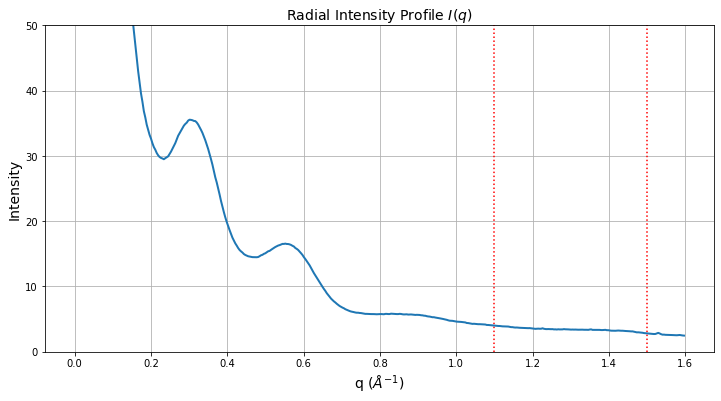

In [26]:
# Set limits for fitting the atomic scattering factor

asf_fit_min, asf_fit_max = 1.1, 1.5

# Plot
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(q_arr,I_q,linewidth=2)
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax.set_ylabel('Intensity',fontsize=14)
ax.set_title('Radial Intensity Profile $I(q)$',fontsize=14)
ax.grid()
ax.set_ylim(0, 50)
ax.vlines((asf_fit_min,asf_fit_max),ax.get_ylim()[0],ax.get_ylim()[1],color='r',ls=':')
plt.show()

In [27]:
# Modified Structure Factor function which will be fit at high values of q to the radial profile 
def intensity_fit(q, N, C):
    '''
    Accepts:
        q: range of recipricol space values over which to produce the atomic scattering factor values 
        N: fit value, number of atoms under central beam 
        C: Background correction factor, determined from fitting 
        
    Function used to fit and determine N from a radial distribution profile'''
    Z = [14] # Designating Silicon
    XZ = [1]
    asf = rdf.single_atom_scatter(Z,XZ,q,'A')
    asf.get_scattering_factor(Z,XZ,q,'A')
    return N*asf.fe**2+C 

In [29]:
# Fit atomic scattering factor

N0 = 10
C0 = 0

q_arr_mask = (q_arr>asf_fit_min)*(q_arr<=asf_fit_max)
q_arr[q_arr_mask]

(N_fit,C_fit),_ = optimize.curve_fit(intensity_fit, q_arr[q_arr_mask], I_q[q_arr_mask], [N0,C0])
single_atom_scattering = intensity_fit(q_arr, N_fit, C_fit)

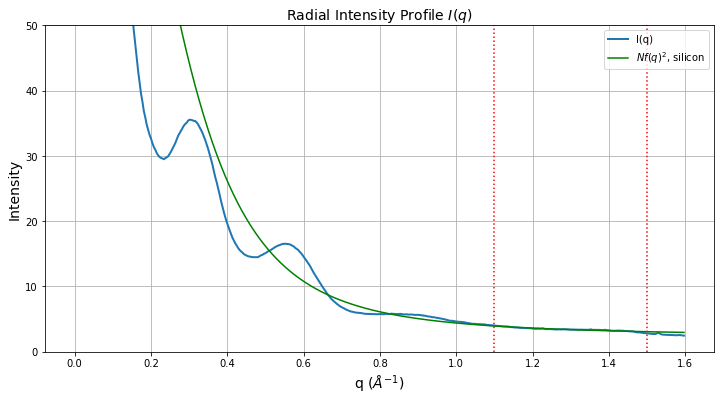

In [31]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(q_arr,I_q,linewidth=2, label='I(q)')
ax.plot(q_arr,single_atom_scattering, color ='g', label='$Nf(q)^{2}$, silicon')
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax.set_ylabel('Intensity',fontsize=14)
ax.set_title('Radial Intensity Profile $I(q)$',fontsize=14)
ax.grid()
ax.set_ylim(0, 50)
ax.vlines((asf_fit_min,asf_fit_max),ax.get_ylim()[0],ax.get_ylim()[1],color='r',ls=':')
ax.legend()
plt.show()

### 4a) Calculating the structure factors

Once the the single atom scattering factors are fit, we can calculate the structure factors $\phi(q)$ through the following relation:

$$\phi(q) = \Bigg [ \frac{I(q) - Nf^2(q)}{Nf^2(q)} \Bigg ] q$$

Here, it should be more clear whether or not the fit of the single atom scattering factor was good enough. $\phi(q)$ should oscillate about the zero axis, and should decay toward zero at high $q$. If $N$ is too large, the high angle tail of $\phi(q)$ will have a negative slope, and if $N$ is too small, it will have a positive slope. 

The get_phi() function has the following parameters:

    radialIntensity: radial intensity profile I(q)
    scatter: single atom scattering factor N*f^2(q)
    q_arr: 1D diffraction space vector
    
get_phi() has one output, which is $\phi(q)$

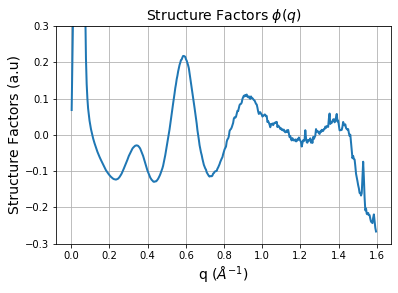

In [33]:
phi = rdf.get_phi(I_q,single_atom_scattering,q_arr)

#plotting
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(q_arr,phi,linewidth=2)
ax.grid()
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax.set_ylabel('Structure Factors (a.u)',fontsize=14)
ax.set_title('Structure Factors $\phi(q)$',fontsize=14)
ax.set_ylim(-0.3,0.3)
plt.show()

### 4b) Masking of the signal

To prevent artifacts at high and low frequencies due to the center beam and the cut off, it can be helpful to include a masking window for the structure factors $\phi(q)$. The mask is monotonically increasing on the left side, and monotonically decereasing on the right side.

The get_mask() function has the following parameters:

    left: midpoint of increasing erf (mask = 0.5 at left) (in units of q) 
    right: midpoint of decreasing erf (mask = 0.5 at right) (in units of q)     
    midpoint: point in q space where mask sides are stitched     
    slopes: relative scale of decay    
    q_arr: 1D diffraction space vector 
    
get_mask() has one output, which is the mask generated by the above parameters

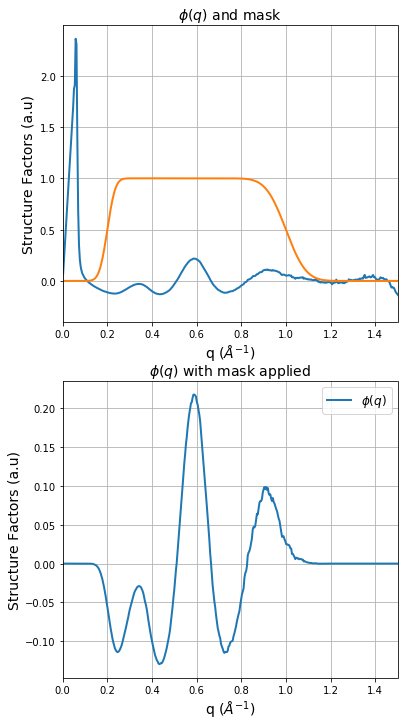

In [39]:
left = 0.2
right = 1
midpoint = 0.5
slopes = [25,10]
phi_mask = rdf.get_mask(left,right,midpoint,slopes,q_arr)

#plotting
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,12))
ax1.plot(q_arr,phi,linewidth=2, label='$\phi(q)$')
ax1.plot(q_arr,phi_mask,linewidth=2, label='$mask$')
ax1.grid()
ax1.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax1.set_ylabel('Structure Factors (a.u)',fontsize=14)
ax1.set_title('$\phi(q)$ and mask',fontsize=14)
ax1.set_xlim([0,1.5])

ax2.plot(q_arr,phi*phi_mask,linewidth=2, label='$\phi(q)$')
ax2.grid()
ax2.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax2.set_ylabel('Structure Factors (a.u)',fontsize=14)
ax2.set_title('$\phi(q)$ with mask applied',fontsize=14)
ax2.legend(fontsize=12)
ax2.set_xlim([0,1.5])
ax2.legend(fontsize=12)

plt.show()

### 6) Calculate the radial distribution function
Once the structure factors have been calculated, we are now ready to compute the radial distribution function. The radial distribution function is calculated with a discrete sine transform, approximating the following relation [1]

$$ G(r) = \int_0^\infty \phi(q)\sin(qr) dr  = 4\pi r \big [ g(r) - \rho_0]$$

where $G(r)$ is the reduced pair distribution function, $g(r)$ is the radial distribution function, and $\rho_0$ is the bulk number density of atoms. In the current implementation, $\rho_0$ is not accounted for in extracting $g(r)$. The discrete sine transforms are computed with those provided in Scipy's FFT pack. Here, we use forward discrete sine transform, type 2, as it was found to be the most stable and accurate in our testing, though mileage may vary. Scaling factors are accounted for in the current implementation. 

The function get_rdf() takes in the following parameters:

    phi: the structure factors (masked or unmasked)
    q_arr: 1D diffraction space vector
    
get_rdf() has two outputs:

    g_r: the radial distribution function
    radius: the real space values at which g_r is computed
    
The output resolution of $g(r)$ is directly dependent on the extent of the radial intensity profile $I(q)$ in diffraction space, and can be calculated as

$$dr = \frac{1}{2q_{max}}  $$

where $dr$ is the real space resolution and $q_{max}$ is the maximum scattering angle included. Signal features closer apart in real space $dr$ cannot be reliably distinguished through discrete fourier transforms wihtout meausring out to higher scattering angles, no matter the noise reduction or masking applied. Zero-padding $\phi(q)$ can help place detectable features in $g(r)$ at more precise radial measurements, however, it still will not help in distinguishing features closer together than $dr$.![Screen Shot 2019-12-05 at 6.57.15 AM.png](attachment:Screen Shot 2019-12-05 at 6.57.15 AM.png)

Maximum resolvable feature distance:  0.3132 angstroms
Peaks at  2.25  and  3.65 angstroms.


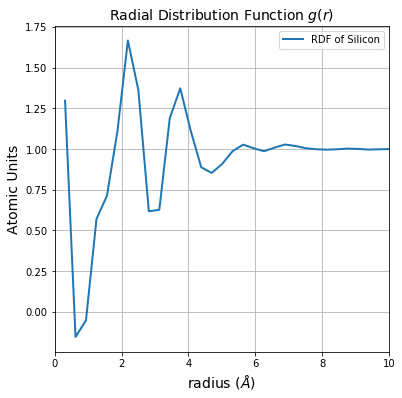

In [43]:
g_r,radius = rdf.get_rdf(phi*phi_mask,q_arr)
dr = 1/(2*np.max(q_arr))
#plotting
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(radius,g_r,linewidth=2,label='reconstructed')
ax.grid()
ax.set_xlabel('radius ($\AA$)',fontsize=14)
ax.set_ylabel('Atomic Units',fontsize=14)
ax.set_title('Radial Distribution Function $g(r)$',fontsize=14)
ax.set_xlim(0,10)
print("Maximum resolvable feature distance: ", np.round(dr,5), "angstroms")
peak1 = 2.25
peak2 = 3.65
#ax.axvline(peak1,color='r',linestyle='--')
#ax.axvline(peak2,color='r',linestyle='--')
ax.legend(['RDF of Silicon', 'Expeted High Intensity Peaks'])
#ax.set_ylim(0.6,1.2)
print("Peaks at ",peak1, " and ",peak2, "angstroms.")

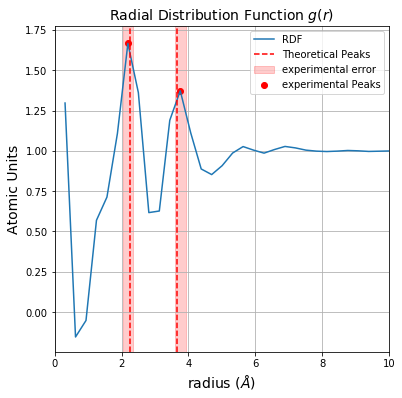

Peaks at  2.19 ± 0.16 angstroms and  3.75 ± 0.16 angstroms.
Peaks expected  2.25  and  3.65 angstroms.


In [45]:
# Let's find our peaks in comparison to the expected location 
peaks_loc = scipy.signal.find_peaks(gaussian_filter(g_r,0), prominence=0.03)[0][0:2]
peaks = [radius[peaks_loc[0]], radius[peaks_loc[1]]]

peak1 = 2.25
peak2 = 3.65

fig, ax =plt.subplots(1,1, figsize=(6,6))
ax.plot(radius, g_r, label = 'RDF')
ax.scatter(peaks, g_r[peaks_loc], color='r', label = 'experimental Peaks')
ax.set_xlim([0,10])
#ax.set_ylim(0,1.5)
ax.axvspan(peaks[0]-dr/2, peaks[0]+dr/2, alpha=0.2, color='red', label = None)
ax.axvspan(peaks[1]-dr/2, peaks[1]+dr/2, alpha=0.2, color='red', label = 'experimental error')
ax.axvline(peak1,color='r',linestyle='--', label = 'Theoretical Peaks')
ax.axvline(peak2,color='r',linestyle='--', label = None)
ax.legend()
ax.set_xlabel('radius ($\AA$)',fontsize=14)
ax.set_ylabel('Atomic Units',fontsize=14)
ax.set_title('Radial Distribution Function $g(r)$',fontsize=14)
ax.grid()

plt.show()

print("Peaks at ",np.round(peaks[0],2),"\xb1",np.round(dr/2,2), "angstroms and ",np.round(peaks[1],2), "\xb1",np.round(dr/2,2), "angstroms.")
print("Peaks expected ",peak1, " and ",peak2, "angstroms.")

### Zero padding

To give us higher sampling in the low frequency domain, we can pad the end of our structure function with zeros since we know the probability of scattering at very high q values goes to zero. This will give us higher sampling in the low frequency domain of our radial distribution function. 

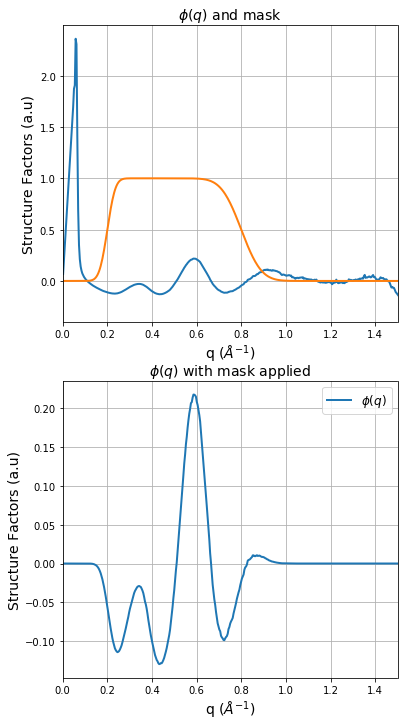

In [53]:
# Zero padding 

pad_factor = 5

q_arr_padded = np.arange(q_arr[0], q_arr[-1]*pad_factor, q_arr[1]-q_arr[0])
phi_padded = np.zeros_like(q_arr_padded)
phi_padded[:len(phi)] = phi
dr_padded = 1/(2*np.max(q_arr))


left = 0.2
right = 0.8
midpoint = 0.5
slopes = [25,10]
phi_mask_padded = rdf.get_mask(left,right,midpoint,slopes,q_arr_padded)
g_r_pad,radius_pad = rdf.get_rdf(phi_padded*phi_mask_padded,q_arr_padded)

# Plot
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,12))
ax1.plot(q_arr_padded,phi_padded,linewidth=2, label='$\phi(q)$')
ax1.plot(q_arr_padded,phi_mask_padded,linewidth=2, label='$mask$')
ax1.grid()
ax1.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax1.set_ylabel('Structure Factors (a.u)',fontsize=14)
ax1.set_title('$\phi(q)$ and mask',fontsize=14)
ax1.set_xlim([0,1.5])

ax2.plot(q_arr_padded,phi_padded*phi_mask_padded,linewidth=2, label='$\phi(q)$')
ax2.grid()
ax2.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax2.set_ylabel('Structure Factors (a.u)',fontsize=14)
ax2.set_title('$\phi(q)$ with mask applied',fontsize=14)
ax2.legend(fontsize=12)
ax2.set_xlim([0,1.5])
ax2.legend(fontsize=12)

plt.show()

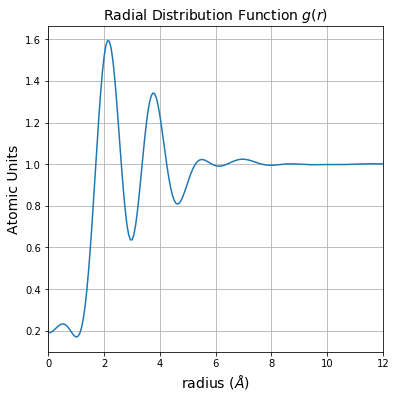

In [55]:
fig, ax =plt.subplots(1,1, figsize=(6,6))
ax.plot(radius_pad, g_r_pad, label = 'RDF')
ax.set_xlim([0,12])
ax.set_xlabel('radius ($\AA$)',fontsize=14)
ax.set_ylabel('Atomic Units',fontsize=14)
ax.set_title('Radial Distribution Function $g(r)$',fontsize=14)
ax.grid()

plt.show()

### More plotting

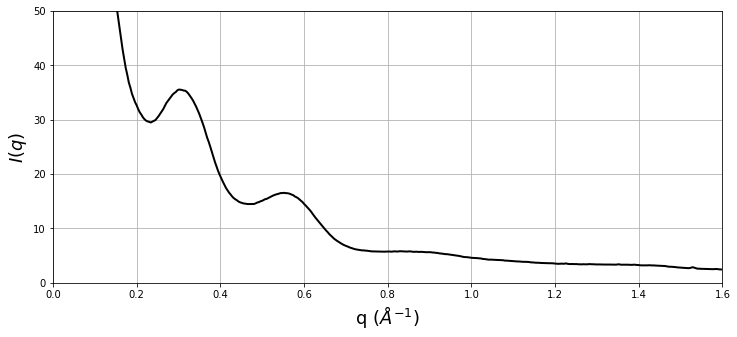

In [81]:
# Intensity profile

fig,ax = plt.subplots(figsize=(12,5))
ax.plot(q_arr,I_q,linewidth=2, color='k')
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=18)
ax.set_ylabel('$I(q)$',fontsize=18)
ax.grid()
ax.set_ylim(0, 50)
ax.set_xlim(0, 1.6)
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/rdf/intensity_profile.pdf")
plt.show()

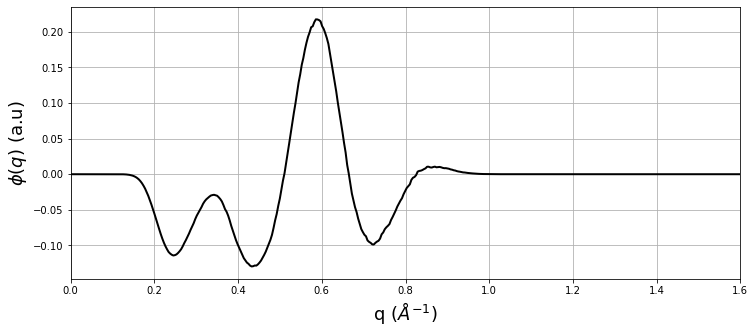

In [82]:
# Structure factor

fig,ax = plt.subplots(figsize=(12,5))
ax.plot(q_arr_padded,phi_padded*phi_mask_padded,linewidth=2, color='k')
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=18)
ax.set_ylabel('$\phi(q)$ (a.u)',fontsize=18)
ax.grid()
ax.set_xlim(0, 1.6)
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/rdf/structure_factor.pdf")
plt.show()

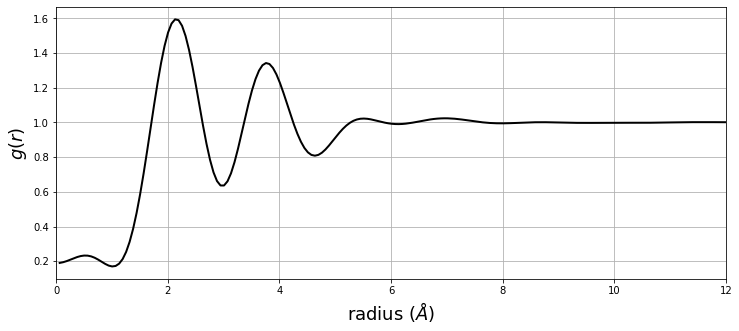

In [83]:
# RDF

fig, ax =plt.subplots(1,1, figsize=(12,5))
ax.plot(radius_pad, g_r_pad,linewidth=2, color='k')
ax.set_xlim([0,12])
ax.set_xlabel('radius ($\AA$)',fontsize=18)
ax.set_ylabel('$g(r)$',fontsize=18)
ax.grid()
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/rdf/radial_distribution_function.pdf")
plt.show()

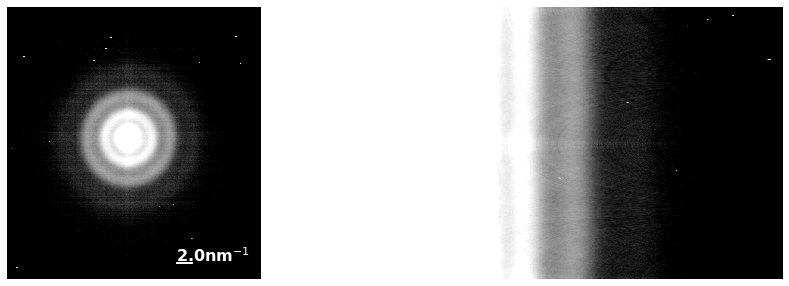

In [84]:
# Ave DP
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_DP**power, vmin=np.mean(ave_DP**power), vmax=np.mean(ave_DP**power)+nstd*np.std(ave_DP**power))
scalebar = Rectangle((scalebar_location[0],scalebar_location[1]), scalebar_size[0],scalebar_size[1], color=scalebar_color)
ax1.add_patch(scalebar)
ax1.text(x=scalebar_location[0], y =scalebar_location[1]-(scalebar_size[1]/2)-1, s=scalebar_label, fontweight='bold', fontsize= 16, color = scalebar_color)
ax2.matshow(polarEllipticalData.data**power, vmin=np.mean(polarEllipticalData**power)-nstd_tl*np.std(polarEllipticalData**power), vmax=np.mean(polarEllipticalData**power)+nstd_tu*np.std(polarEllipticalData**power))
ax1.axis('off')
ax2.axis('off')
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/rdf/diffraction_data.pdf")
plt.show()

### Older code

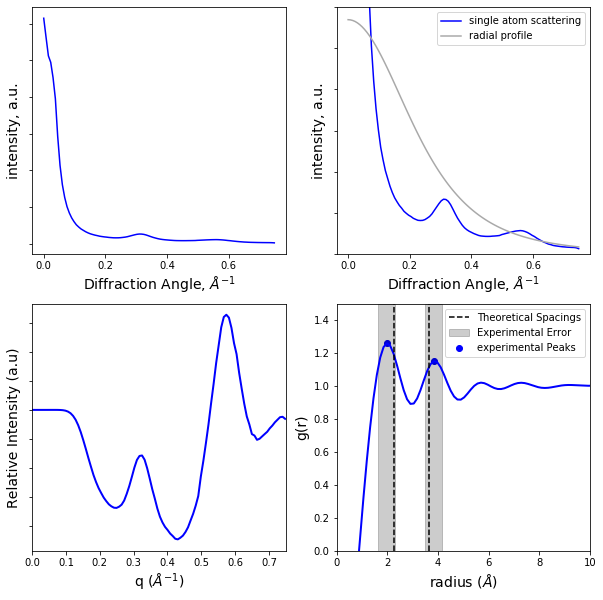

In [62]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0,0].plot(q_arr,I_q, color='b')
# ax[0,0].set_ylim([0,np.max(pet.polar_ar)**0.1])
ax[0,0].set_xlabel('Diffraction Angle, $\AA^{-1}$',fontsize=14)
ax[0,0].set_ylabel('intensity, a.u.', fontsize=14)
ax[0,0].set_yticklabels('')

ax[0,1].plot(q_arr,I_q, color='b')
ax[0,1].plot(q_arr,single_atom_scattering, color='darkgray')
ax[0,1].set_ylim([0,np.max(pet.polar_ar)**0.1])
ax[0,1].legend(['single atom scattering', 'radial profile', 'fit start'])
ax[0,1].set_xlabel('Diffraction Angle, $\AA^{-1}$',fontsize=14)
ax[0,1].set_ylabel('intensity, a.u.',fontsize=14)
ax[0,1].set_yticklabels('')

ax[1,0].plot(q_arr,phi*phi_mask,linewidth=2, label='$\phi(q)$', color = 'b')
ax[1,0].set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax[1,0].set_ylabel('Relative Intensity (a.u)',fontsize=14)
ax[1,0].set_xlim([0,0.75])
ax[1,0].set_yticklabels('')

ax[1,1].plot(radius_pad,g_r_pad,linewidth=2, label = None, color='b')
ax[1,1].scatter(peaks, g_r_pad[peaks_loc], color='b', label = 'experimental Peaks')
ax[1,1].set_xlim([0,10])
ax[1,1].set_ylim(0,1.5)
ax[1,1].axvspan(peaks[0]-dr_padded/2, peaks[0]+dr_padded/2, alpha=0.2, color='k', label = None)
ax[1,1].axvspan(peaks[1]-dr_padded/2, peaks[1]+dr_padded/2, alpha=0.2, color='k', label = 'Experimental Error')
ax[1,1].axvline(peak1,color='k',linestyle='--', label = 'Theoretical Spacings')
ax[1,1].axvline(peak2,color='k',linestyle='--', label = None)
ax[1,1].legend()
ax[1,1].set_xlabel('radius ($\AA$)',fontsize=14)
ax[1,1].set_ylabel('g(r)',fontsize=14)
# ax[1,1].set_title('Radial Distribution Function $g(r)$',fontsize=14)

plt.show()

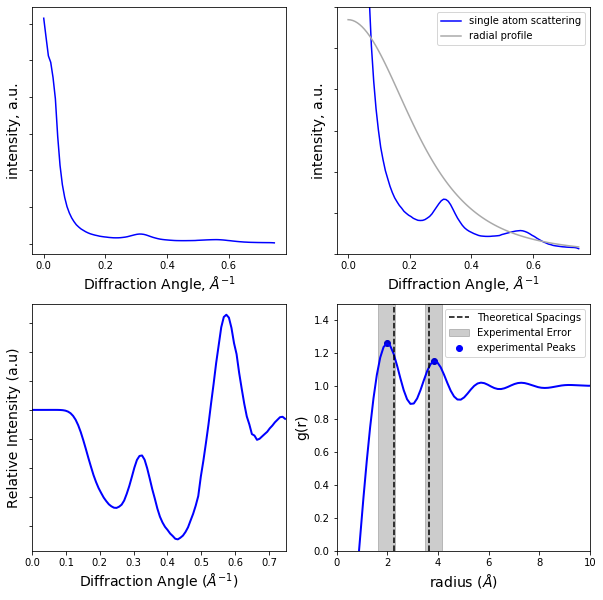

In [67]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0,0].plot(q_arr,I_q, color='b')
# ax[0,0].set_ylim([0,np.max(pet.polar_ar)**0.1])
ax[0,0].set_xlabel('Diffraction Angle, $\AA^{-1}$',fontsize=14)
ax[0,0].set_ylabel('intensity, a.u.', fontsize=14)
ax[0,0].set_yticklabels('')

ax[0,1].plot(q_arr,I_q, color='b')
ax[0,1].plot(q_arr,single_atom_scattering, color='darkgray')
ax[0,1].set_ylim([0,np.max(pet.polar_ar)**0.1])
ax[0,1].legend(['single atom scattering', 'radial profile', 'fit start'])
ax[0,1].set_xlabel('Diffraction Angle, $\AA^{-1}$',fontsize=14)
ax[0,1].set_ylabel('intensity, a.u.',fontsize=14)
ax[0,1].set_yticklabels('')

ax[1,0].plot(q_arr,phi*phi_mask,linewidth=2, label='$\phi(q)$', color = 'b')
ax[1,0].set_xlabel('Diffraction Angle ($\AA^{-1}$)',fontsize=14)
ax[1,0].set_ylabel('Relative Intensity (a.u)',fontsize=14)
ax[1,0].set_xlim([0,0.75])
ax[1,0].set_yticklabels('')

ax[1,1].plot(radius_pad,g_r_pad,linewidth=2, label = None, color='b')
ax[1,1].scatter(peaks, g_r_pad[peaks_loc], color='b', label = 'experimental Peaks')
ax[1,1].set_xlim([0,10])
ax[1,1].set_ylim(0,1.5)
ax[1,1].axvspan(peaks[0]-dr_padded/2, peaks[0]+dr_padded/2, alpha=0.2, color='k', label = None)
ax[1,1].axvspan(peaks[1]-dr_padded/2, peaks[1]+dr_padded/2, alpha=0.2, color='k', label = 'Experimental Error')
ax[1,1].axvline(peak1,color='k',linestyle='--', label = 'Theoretical Spacings')
ax[1,1].axvline(peak2,color='k',linestyle='--', label = None)
ax[1,1].legend()
ax[1,1].set_xlabel('radius ($\AA$)',fontsize=14)
ax[1,1].set_ylabel('g(r)',fontsize=14)

plt.show()

Text(0, 0.5, 'g(r)')

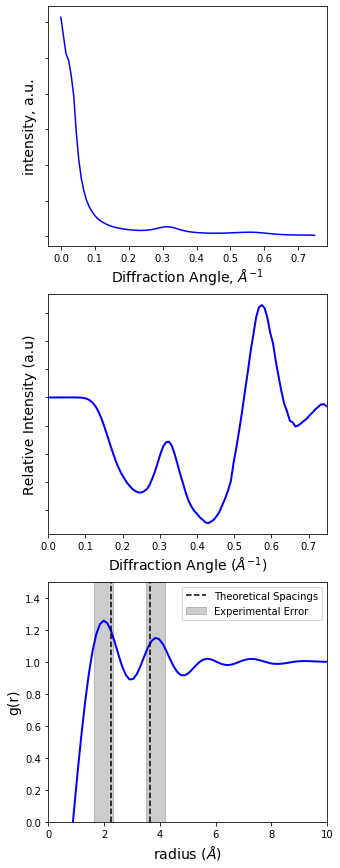

In [113]:
fig, ax = plt.subplots(3,1, figsize = [5,15])
ax[0].plot(q_arr,I_q, color='b')
ax[0].set_xlabel('Diffraction Angle, $\AA^{-1}$',fontsize=14)
ax[0].set_ylabel('intensity, a.u.', fontsize=14)
ax[0].set_yticklabels('')

ax[1].plot(q_arr,phi*phi_mask,linewidth=2, label='$\phi(q)$', color = 'b')
ax[1].set_xlabel('Diffraction Angle ($\AA^{-1}$)',fontsize=14)
ax[1].set_ylabel('Relative Intensity (a.u)',fontsize=14)
ax[1].set_xlim([0,0.75])
ax[1].set_yticklabels('')

ax[2].plot(radius_pad,g_r_pad,linewidth=2, label = None, color='b')
# ax[2].scatter(peaks, g_r_pad[peaks_loc], color='b', label = 'experimental Peaks')
ax[2].set_xlim([0,10])
ax[2].set_ylim(0,1.5)
ax[2].axvspan(peaks[0]-dr_padded/2, peaks[0]+dr_padded/2, alpha=0.2, color='k', label = None)
ax[2].axvspan(peaks[1]-dr_padded/2, peaks[1]+dr_padded/2, alpha=0.2, color='k', label = 'Experimental Error')
ax[2].axvline(peak1,color='k',linestyle='--', label = 'Theoretical Spacings')
ax[2].axvline(peak2,color='k',linestyle='--', label = None)
ax[2].legend()
ax[2].set_xlabel('radius ($\AA$)',fontsize=14)
ax[2].set_ylabel('g(r)',fontsize=14)

Next we're going to give every pixel in our pattern a radius or distance from the center (x0,y0) of the pattern. To do this we'll start with a mesh grid, then calculate the radius from the cartesian coordinates. 

In [18]:
yy,xx = np.meshgrid(np.arange(dc.data.shape[3]),np.arange(dc.data.shape[2])) # creating a mesh grid of the cartesian 
                                                                            # coordinates the size of the diffraction pattern
rr = np.sqrt((xx-x0)**2 + (yy-y0)**2) # the radius of each pixel from the center 

Now we'll take our elliptical polar transform using our elliptical parameters, assigned center point, and grid of radial distances. To do this, we'll fit a function that uses two things: (1) it fits a one-sided guassian to the center beam, and it fits a two-sided guassian to the amorphous ring. 

To do this we'll need to define some parameters. 
1. **bkgd_init**: the average background intensity; to get this we'll average the edges of the pattern where the major contribution will come from the background
2. **I_BG_init** : the average center disk intensity per pixel
3. **SD_BG_init**: Standard deviation of center guassian 
4. **I_ring_init**:  the average intensity in an amorphous ring. We'll take a look at our pattern and define a ring, by eye to initialize this
5. **SD_1_init**: standard deviation of the right side of ammorphous ring guassian 
6. **SD_2_init**: standard deviation of the left side fo ammorphous ring guassian
7. **B_init**: elliptical parameter 'B', we already have this one 
8. **C_init**:  elliptical parameter 'C', we already have this one 
9. **R_init**: the radial location of amorphous ring from the center 
10. **dr**: radial bin size
11. **dtheta**: theta bin size 
12. **r_range**: can be set as a range or just a maximum, it's the maximum radius that will be included in the transform 


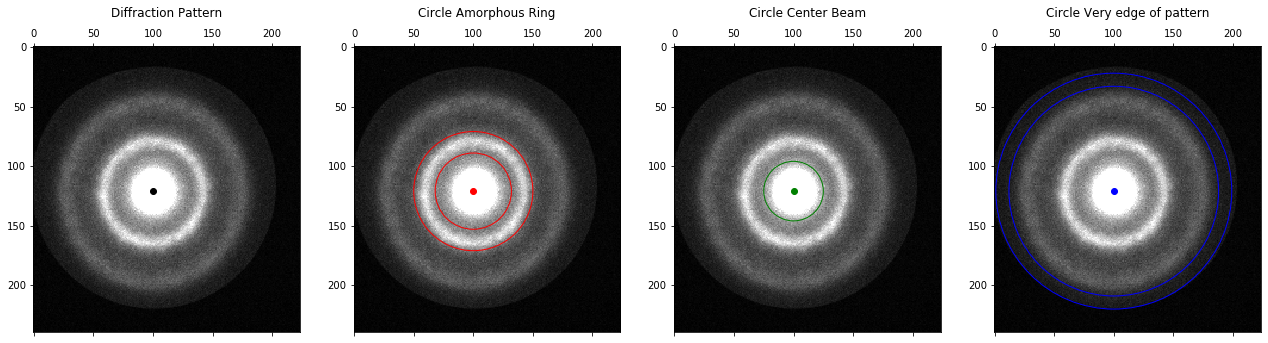

In [19]:
# Find the Amorphous Ring 
radius_outer, radius_inner = 50,32 # select these parameters such that an amorphous ring is 'ringed'

circle_inner = Circle((y0,x0),radius=radius_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=radius_outer, fill=False, edgecolor='r', linestyle="-")

# Find the center disk 
radius_center = 25
circle_center = Circle((y0,x0),radius=radius_center, fill=False, edgecolor='g', linestyle="-")

# Find the background 
radius_bkgrd_outer, radius_bkgrd_inner = 99,88
circle_bkgrd_outer = Circle((y0,x0),radius=radius_bkgrd_outer, fill=False, edgecolor='b', linestyle="-")
circle_bkgrd_inner = Circle((y0,x0),radius=radius_bkgrd_inner, fill=False, edgecolor='b', linestyle="-")

fig, ax = plt.subplots(1,4,figsize = [22,6])
ax[0].set_title('Diffraction Pattern', pad =15)
ax[1].set_title('Circle Amorphous Ring', pad=15)
ax[2].set_title('Circle Center Beam', pad=15)
ax[3].set_title('Circle Very edge of pattern', pad=15)
ax[0].matshow(avg_DP.data[:,:,0], vmin = 0, vmax = np.max(avg_DP.data[:,:,0])*0.05)
ax[1].matshow(avg_DP.data[:,:,0], vmin = 0, vmax = np.max(avg_DP.data[:,:,0])*0.05)
ax[2].matshow(avg_DP.data[:,:,0], vmin = 0, vmax = np.max(avg_DP.data[:,:,0])*0.05)
ax[3].matshow(avg_DP.data[:,:,0], vmin = 0, vmax = np.max(avg_DP.data[:,:,0])*0.05)
ax[1].add_patch(circle_inner)
ax[1].add_patch(circle_outer)
ax[2].add_patch(circle_center)
ax[3].add_patch(circle_bkgrd_outer)
ax[3].add_patch(circle_bkgrd_inner)
ax[0].scatter(y0,x0, color ='k')
ax[1].scatter(y0,x0, color ='r')
ax[2].scatter(y0,x0, color ='g')
ax[3].scatter(y0,x0, color ='b')
plt.show()

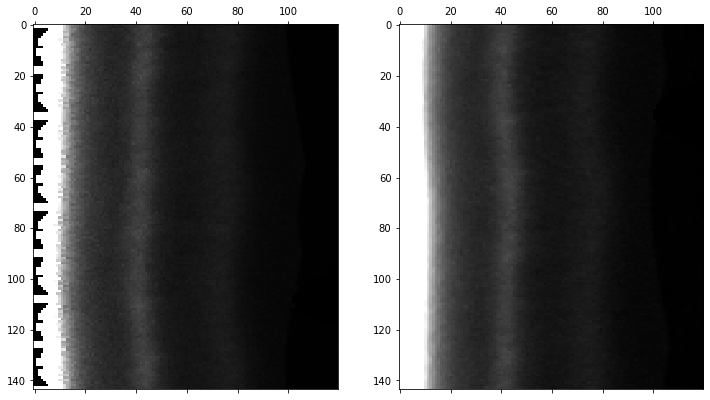

In [20]:
# Get initial polar transform

dr= 1           # in pixels
dtheta= 2.5       # in degrees
r_range= 120  # either [min,max] or just max --> [0,max], we'll set it as the max distance in our pattern
bkgd_init = np.sum(avg_DP.data[:,:,0]*(np.logical_and((rr<radius_bkgrd_outer),(rr>radius_bkgrd_inner))))/np.sum(np.logical_and((rr<radius_bkgrd_outer),(rr>radius_bkgrd_inner)))
I_BG_init = np.sum(avg_DP.data[:,:,0]*(rr<15))/np.sum(rr<15) # Intensity of Guassian 
SD_BG_init = radius_center*2
I_ring_init = np.sum(avg_DP.data[:,:,0]*(np.logical_and((rr<radius_outer),(rr>radius_inner))))/np.sum(np.logical_and((rr<radius_outer),(rr>radius_inner)))
SD_1_init = (radius_outer-radius_inner) # 15 GUASSIAN SD 1
SD_2_init = (radius_outer-radius_inner)  # 25 Guassian side 2 SD2
x0_init= x0
y0_init= y0 
B_init = pet.coefs[4]
C_init = pet.coefs[3]
R_init = radius_inner + (radius_outer-radius_inner)/2
init_coef = [bkgd_init,I_BG_init,SD_BG_init,I_ring_init,
              SD_1_init,SD_2_init,x0_init,y0_init,
              B_init,C_init,R_init]
##############

# Perform transform
pet = polar_elliptical_transform(calibration_image=avg_DP.data[:,:,0],
#                                  mask=np.ones_like(avg_DP.data[:,:,0]),
                                 x0_init=x0_init,
                                 y0_init=y0_init,
                                 dr=dr,
                                 dtheta=dtheta,
                                 r_range=r_range)
pet.get_polar_transform()


pet.get_polar_transform_twoSided_gaussian(coef = init_coef)
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].matshow(pet.polar_ar,vmin=0,vmax=np.max(pet.polar_ar)**0.05)
colin= pet.polar_ar
pet.get_polar_transform()
ben = pet.polar_ar
ax[1].matshow(pet.polar_ar,vmin=0,vmax=np.max(pet.polar_ar)**0.05)

plt.show()

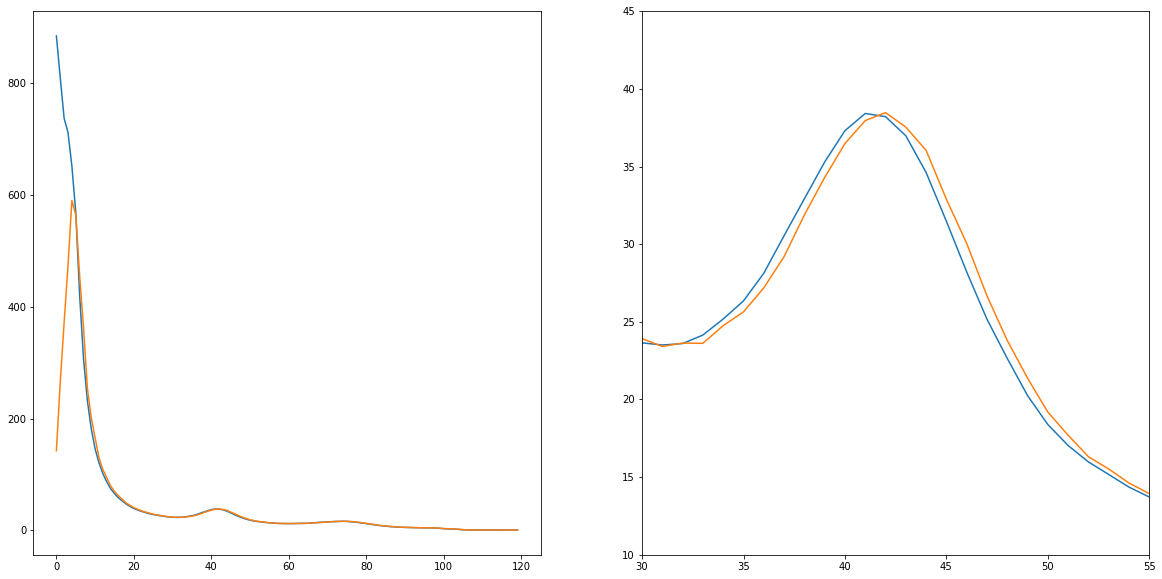

In [21]:
fig, ax = plt.subplots(1,2, figsize=[20,10])
ax[0].plot(np.sum(ben, axis= 0))
ax[0].plot(np.sum(colin, axis=0))
ax[1].plot(np.sum(ben, axis= 0))
ax[1].plot(np.sum(colin, axis=0))
ax[1].set_xlim([30,55])
ax[1].set_ylim([10,45])

plt.show()